In [1]:
import numpy as np

import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
tf.compat.v1.disable_eager_execution()


In [2]:
# 加载了数据
mnist = input_data.read_data_sets('./',one_hot=True)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [3]:
# 创建变量占位符

X = tf.compat.v1.placeholder(dtype=tf.float64,shape = [None,784])

y = tf.compat.v1.placeholder(dtype=tf.float64,shape = [None,10])

In [4]:
# 卷积核，在卷积神经网络中，是变量
# 变量生成方法
def gen_v(shape):
    return tf.Variable(initial_value=tf.random.normal(dtype = tf.float64,shape = shape,stddev = 0.1),dtype=tf.float64)

In [5]:
# 定义方法，完成卷积操作
def conv(input_data,filter_):
    return tf.nn.conv2d(input=input_data,filters=filter_,strides=[1,1,1,1],padding='SAME')


# 定义，池化操作
def pool(input_data):
    return tf.nn.max_pool(input=input_data,ksize = [1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [6]:
X

<tf.Tensor 'Placeholder:0' shape=(None, 784) dtype=float64>

In [7]:
img = mnist.train.images[0]
img.shape

(784,)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

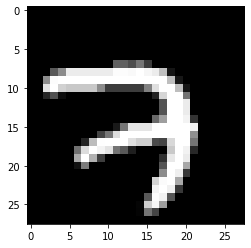

In [9]:
plt.imshow(img.reshape(28,28),cmap = plt.cm.gray)

In [10]:
# 第一层卷积
input_data1 = tf.reshape(X,shape = [-1,28,28,1])

# 卷积核
filter1 = gen_v(shape = [3,3,1,64])

# 偏差bias
b1 = gen_v(shape = [64])

conv1 = conv(input_data1,filter1) + b1

# 池化
pool1 = pool(conv1)

# 激活函数
active1 = tf.nn.relu(pool1)
active1

<tf.Tensor 'Relu:0' shape=(None, 14, 14, 64) dtype=float64>

In [11]:
# 系数 640 个

In [12]:
# 第二层卷积
# 使用的是第一层卷积的数据

filter2 = gen_v(shape = [3,3,64,64])
b2 = gen_v(shape = [64])

conv2 = conv(active1,filter2) + b2


# 池化
pool2 = pool(conv2)

# 激活
active2 = tf.nn.sigmoid(pool2)
active2

<tf.Tensor 'Sigmoid:0' shape=(None, 7, 7, 64) dtype=float64>

In [13]:
# 第二层卷积 36928系数 float64

In [14]:
# 全连接层,矩阵运算
# 1024个连接，1024方程，1024神经元
fc_w = gen_v(shape = [7*7*64,1024])

fc_b = gen_v(shape = [1024])

conn = tf.matmul(tf.reshape(active2,shape = [-1,7*7*64]),fc_w) + fc_b
conn
# ? ? ? shape = [?,1024]

<tf.Tensor 'add_2:0' shape=(None, 1024) dtype=float64>

In [15]:
# 全连接层3212288 系数

In [16]:
# dropout 防止过拟合
kp = tf.compat.v1.placeholder(dtype=tf.float64,shape = None)
dropout = tf.nn.dropout(conn,rate=kp)
dropout

<tf.Tensor 'dropout/Mul:0' shape=(None, 1024) dtype=float64>

In [17]:
# 输出层out
# 10个类别 0 ~ 9
out_w = gen_v(shape = [1024,10])
out_b = gen_v(shape = [10])

out = tf.matmul(dropout,out_w) + out_b
out
# ? ? ? shape = [?,10]

<tf.Tensor 'add_3:0' shape=(None, 10) dtype=float64>

In [18]:
# 概率，预测的概率，非真实分布
prob = tf.nn.softmax(out)
prob

<tf.Tensor 'Softmax:0' shape=(None, 10) dtype=float64>

In [19]:
# 真实概率是y
y

<tf.Tensor 'Placeholder_1:0' shape=(None, 10) dtype=float64>

In [20]:
# 交叉熵
cost = tf.reduce_mean(tf.reduce_sum(y*tf.math.log(1/prob),axis = -1))
cost

<tf.Tensor 'Mean:0' shape=() dtype=float64>

In [21]:
cost2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=prob))
cost2

<tf.Tensor 'Mean_1:0' shape=() dtype=float64>

In [22]:
adam = tf.compat.v1.train.AdamOptimizer()


In [23]:
optimizer = adam.minimize(cost)
optimizer

<tf.Operation 'Adam' type=NoOp>

In [24]:
saver = tf.compat.v1.train.Saver()

In [25]:
# gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)  
config_=tf.compat.v1.ConfigProto(gpu_options=gpu_options,log_device_placement=True,allow_soft_placement=True)

with tf.compat.v1.Session(config=config_) as sess:    
    sess.run(tf.compat.v1.global_variables_initializer())
    for i in range(10):
        c = 0
        for j in range(100):
            X_train,y_train = mnist.train.next_batch(550)
            optimizer_,cost_ = sess.run(fetches = [optimizer,cost],
                                        feed_dict= {X:X_train,y:y_train,kp:0.5})
            
            c += cost_/100
            print('里层循环次数：%d，每次损失：%0.4f'%(j,cost_))
            
        print('--------------执行次数：%d损失函数是：%0.4f----------------'%(i,c))
        saver.save(sess,save_path='./cnn/model',global_step=i)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5

里层循环次数：0，每次损失：19.4363
里层循环次数：1，每次损失：39.1732
里层循环次数：2，每次损失：56.4708
里层循环次数：3，每次损失：63.7140
里层循环次数：4，每次损失：67.5821
里层循环次数：5，每次损失：56.8000
里层循环次数：6，每次损失：44.7252
里层循环次数：7，每次损失：29.1671
里层循环次数：8，每次损失：30.2349
里层循环次数：9，每次损失：36.0579
里层循环次数：10，每次损失：31.4160
里层循环次数：11，每次损失：31.2929
里层循环次数：12，每次损失：29.5064
里层循环次数：13，每次损失：22.6017
里层循环次数：14，每次损失：26.5851
里层循环次数：15，每次损失：18.7406
里层循环次数：16，每次损失：16.2361
里层循环次数：17，每次损失：14.6804
里层循环次数：18，每次损失：18.4296
里层循环次数：19，每次损失：19.8394
里层循环次数：20，每次损失：19.2748
里层循环次数：21，每次损失：15.6148
里层循环次数：22，每次损失：12.7737
里层循环次数：23，每次损失：13.6853
里层循环次数：24，每次损失：12.2630
里层循环次数：25，每次损失：8.3435
里层循环次数：26，每次损失：10.1248
里层循环次数：27，每次损失：9.1051
里层循环次数：28，每次损失：9.9675
里层循环次数：29，每次损失：9.7219
里层循环次数：30，每次损失：8.6782
里层循环次数：31，每次损失：7.4648
里层循环次数：32，每次损失：7.4534
里层循环次数：33，每次损失：6.7571
里层循环次数：34，每次损失：5.9586
里层循环次数：35，每次损失：6.2929
里层循环次数：36，每次损失：6.6358
里层循环次数：37，

里层循环次数：60，每次损失：0.2029
里层循环次数：61，每次损失：0.2409
里层循环次数：62，每次损失：0.2237
里层循环次数：63，每次损失：0.1983
里层循环次数：64，每次损失：0.3025
里层循环次数：65，每次损失：0.2444
里层循环次数：66，每次损失：0.2340
里层循环次数：67，每次损失：0.2160
里层循环次数：68，每次损失：0.2257
里层循环次数：69，每次损失：0.2061
里层循环次数：70，每次损失：0.2998
里层循环次数：71，每次损失：0.2367
里层循环次数：72，每次损失：0.2302
里层循环次数：73，每次损失：0.2165
里层循环次数：74，每次损失：0.2315
里层循环次数：75，每次损失：0.2713
里层循环次数：76，每次损失：0.3051
里层循环次数：77，每次损失：0.2498
里层循环次数：78，每次损失：0.1736
里层循环次数：79，每次损失：0.2488
里层循环次数：80，每次损失：0.2528
里层循环次数：81，每次损失：0.2690
里层循环次数：82，每次损失：0.1910
里层循环次数：83，每次损失：0.1758
里层循环次数：84，每次损失：0.2283
里层循环次数：85，每次损失：0.2578
里层循环次数：86，每次损失：0.2006
里层循环次数：87，每次损失：0.2294
里层循环次数：88，每次损失：0.2877
里层循环次数：89，每次损失：0.1977
里层循环次数：90，每次损失：0.3220
里层循环次数：91，每次损失：0.2316
里层循环次数：92，每次损失：0.2479
里层循环次数：93，每次损失：0.1915
里层循环次数：94，每次损失：0.2186
里层循环次数：95，每次损失：0.1606
里层循环次数：96，每次损失：0.2426
里层循环次数：97，每次损失：0.1900
里层循环次数：98，每次损失：0.2788
里层循环次数：99，每次损失：0.1584
--------------执行次数：3损失函数是：0.2364----------------
里层循环次数：0，每次损失：0.2030
里层循环次数：1，每次损失：0.1666
里层循环次数：2，每次损失：0.2200
里层循环次数：3

里层循环次数：11，每次损失：0.1632
里层循环次数：12，每次损失：0.1224
里层循环次数：13，每次损失：0.1027
里层循环次数：14，每次损失：0.1627
里层循环次数：15，每次损失：0.1563
里层循环次数：16，每次损失：0.1491
里层循环次数：17，每次损失：0.1058
里层循环次数：18，每次损失：0.1917
里层循环次数：19，每次损失：0.1232
里层循环次数：20，每次损失：0.1004
里层循环次数：21，每次损失：0.1298
里层循环次数：22，每次损失：0.1088
里层循环次数：23，每次损失：0.1286
里层循环次数：24，每次损失：0.1475
里层循环次数：25，每次损失：0.1543
里层循环次数：26，每次损失：0.1012
里层循环次数：27，每次损失：0.1284
里层循环次数：28，每次损失：0.1939
里层循环次数：29，每次损失：0.1340
里层循环次数：30，每次损失：0.1273
里层循环次数：31，每次损失：0.1120
里层循环次数：32，每次损失：0.1246
里层循环次数：33，每次损失：0.1407
里层循环次数：34，每次损失：0.1533
里层循环次数：35，每次损失：0.0941
里层循环次数：36，每次损失：0.1682
里层循环次数：37，每次损失：0.1442
里层循环次数：38，每次损失：0.1388
里层循环次数：39，每次损失：0.1032
里层循环次数：40，每次损失：0.1807
里层循环次数：41，每次损失：0.1607
里层循环次数：42，每次损失：0.1836
里层循环次数：43，每次损失：0.1481
里层循环次数：44，每次损失：0.1747
里层循环次数：45，每次损失：0.2013
里层循环次数：46，每次损失：0.1305
里层循环次数：47，每次损失：0.1417
里层循环次数：48，每次损失：0.1449
里层循环次数：49，每次损失：0.1233
里层循环次数：50，每次损失：0.1391
里层循环次数：51，每次损失：0.1936
里层循环次数：52，每次损失：0.1232
里层循环次数：53，每次损失：0.0747
里层循环次数：54，每次损失：0.1022
里层循环次数：55，每次损失：0.1390
里层循环次数：56，

In [28]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess,'./cnn/model-9')
    
    X_test,y_test = mnist.test.next_batch(2000)
    
    
    prob_ = sess.run(prob,feed_dict = {X:X_test,kp:1.0})
    
    
    y_test = y_test.argmax(axis = -1)
    
    prob_ = prob_.argmax(axis = -1)
    
    print((y_test == prob_).mean())

INFO:tensorflow:Restoring parameters from ./cnn/model-9
0.0925
